# Cookie Cats A/B Testing
https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

    userid - a unique number that identifies each player.

    version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).

    sum_gamerounds - the number of game rounds played by the player during the first week after installation

    retention_1 - did the player come back and play 1 day after installing?

    retention_7 - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

# Preprocessing data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import math
import numpy as np
import scipy
import seaborn as sns
from scipy.stats import shapiro
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('../gaming ab test/cookie_cats.csv')

In [3]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
data.duplicated().sum()

0

**Data is clean**

#  EDA

Going to analyze the behavior of players from different version groups

In [6]:
version_data=data.groupby('version').agg({'sum_gamerounds':['count','min','max', 'mean', 'median', 'var', 'std', 'sum']})
version_data.columns=['players','min','max', 'mean', 'median', 'var', 'std', 'played rounds' ]
version_data.style.set_table_attributes("style='display:inline'").set_caption('Sum of gamerounds stats')

,players,min,max,mean,median,var,std,played rounds
version,,,,,,,,
gate_30,44700,0,49854,52.456264,17.000000,65903.321897,256.716423,2344795
gate_40,45489,0,2640,51.298776,16.000000,10669.736422,103.294416,2333530


Almost the same number of players in each group. Almost the same number of played rounds. Gate_30 has an anomaly in maximum value. Mean, median are almost equal

In [7]:
data.pivot_table(index='version', values=['retention_1', 'retention_7'], aggfunc='mean')

,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


The retention rates of groups are quite close

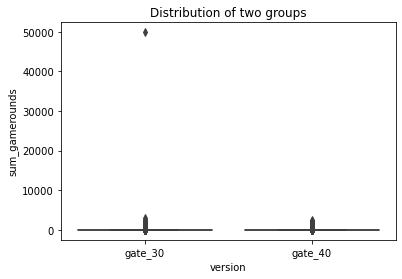

In [8]:
sns.boxplot(x = data.version, y = data.sum_gamerounds).set_title('Distribution of two groups')
plt.show()

In [9]:
gate30=data.query('version=="gate_30"')
gate40=data.query('version=="gate_40"')

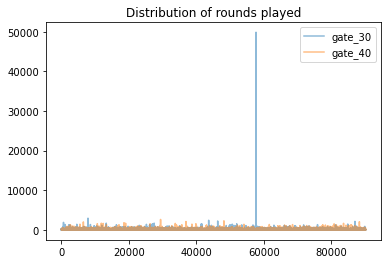

In [10]:
gate30['sum_gamerounds'].plot(label='gate_30', legend=1, alpha=0.5, title='Distribution of rounds played')
gate40['sum_gamerounds'].plot(label='gate_40', legend=1, alpha=0.5)
plt.show()

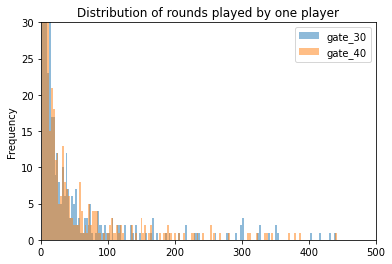

In [42]:
plt30=gate30.groupby('sum_gamerounds')['userid'].count()
plt40=gate40.groupby('sum_gamerounds')['userid'].count()
plt30.plot(kind='hist', bins=1000,xlim=(0,500),ylim=(0,30)
                                                    ,title='Distribution of rounds played by one player'
                                                      , label='gate_30', legend=1, alpha=0.5,x='sum_gamerounds', y='userid')

plt40.plot(kind='hist',bins=1000,
                                                    label='gate_40', legend=1, alpha=0.5,x='sum_gamerounds', y='userid')
plt.show()

Most of the players played less than 100 rounds

Outlying value is clearly observed. Going to remove outliers larger than 0.95 quantile

In [12]:
def outlier_removed(data1,data2,x):
    dc_1 = data1[data1.sum_gamerounds <=data1.sum_gamerounds.quantile(x)]
    dc_2 = data2[data2.sum_gamerounds <=data2.sum_gamerounds.quantile(x)]
    dc = pd.concat([dc_1,dc_2])
    return dc

data_clean =  outlier_removed(gate30,gate40, 0.95)

In [13]:
gate30_clean=data_clean.query('version=="gate_30"').reset_index()
gate40_clean=data_clean.query('version=="gate_40"').reset_index()

Let's explore the data after deleting the outliers

In [14]:
version_data_clean=data_clean.groupby('version').agg({'sum_gamerounds':['count','min','max', 'mean', 'median', 'var', 'std', 'sum']})
version_data_clean.columns=['players','min','max', 'mean', 'median', 'var', 'std', 'played rounds' ]
version_data_clean.style.set_table_attributes("style='display:inline'").set_caption('Sum of gamerounds stats')

,players,min,max,mean,median,var,std,played rounds
version,,,,,,,,
gate_30,42477,0,222,33.233821,15.000000,1947.873474,44.134720,1411673
gate_40,43225,0,220,33.091868,15.000000,1941.031977,44.057144,1430396


Stats are quite simillar now

In [15]:
data_clean.pivot_table(index='version', values=['retention_1', 'retention_7'], aggfunc='mean')

,retention_1,retention_7
version,,
gate_30,0.422440,0.154719
gate_40,0.416356,0.146003


Retention rates have dropped down. But still quite close to each other

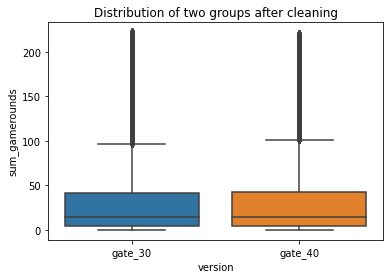

In [16]:
sns.boxplot(x = data_clean.version, y = data_clean.sum_gamerounds).set_title('Distribution of two groups after cleaning')
plt.show()

Looks much better now

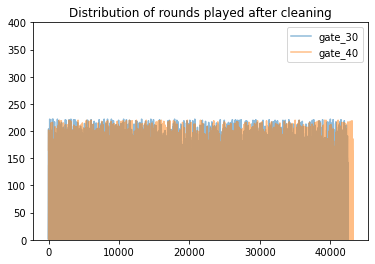

In [17]:
gate30_clean['sum_gamerounds'].plot(label='gate_30', legend=1, alpha=0.5, title='Distribution of rounds played after cleaning'
                                   , ylim=(0,400))
gate40_clean['sum_gamerounds'].plot(label='gate_40', legend=1, alpha=0.5)
plt.show()

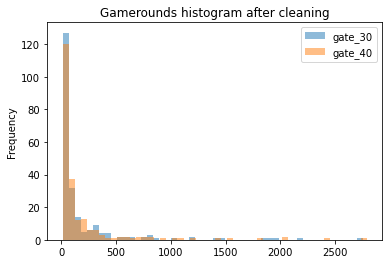

In [36]:
plot30=gate30_clean.groupby('sum_gamerounds')['userid'].count()
plot40=gate40_clean.groupby('sum_gamerounds')['userid'].count()
plot30.plot(kind='hist', bins=50,title='Gamerounds histogram after cleaning', label='gate_30', legend=1, alpha=0.5
            ,x='sum_gamerounds', y='userid')
plot40.plot(kind='hist', bins=50, label='gate_40', legend=1, alpha=0.5, x='sum_gamerounds', y='userid')
plt.show()

Looks like the behavior of the players is quite the same. Let's do AB testing

# Gamerounds A/B Testing

'sum_gamerounds' is a continuous metric. So first of all we need to apply **Shapiro-Wilk** test to check if each group was drawn
from a normal distribution

In [19]:
#checking gate 30
group30=gate30_clean['sum_gamerounds']
sh30=shapiro(group30)
print(sh30)

ShapiroResult(statistic=0.7242306470870972, pvalue=0.0)


In [20]:
#checking gate 40
group40=gate40_clean['sum_gamerounds']
sh40=shapiro(group40)
print(sh40)

ShapiroResult(statistic=0.7269339561462402, pvalue=0.0)


Pvalue = 0. So distributions of gate30 and gate 40 are not normal. Therefore we can use **Mann Whitney U Test**

A-gate30, B-gate40

H0: A==B

H1: A!=B

alpha=0.05

In [21]:
st.mannwhitneyu(group30, group40)

MannwhitneyuResult(statistic=925675263.5, pvalue=0.03476759705137729)

**Reject H0**, groups are not simillar in terms of gamerounds

# Retention A/B Testing

Retention is discrete metric. As we have large sample size, im going to apply **Pearson's Chi square test**

Hyphothesis for retention rate:

H0: A==B

H1: A!=B

alpha=0.05

In [22]:
#checking retention_1
group30_r1=gate30_clean['retention_1']
group40_r1=gate40_clean['retention_1']


In [23]:
table_r1=pd.DataFrame({'30_count': group30_r1.value_counts(),'40_count': group40_r1.value_counts()}).to_numpy()

In [24]:
stat, p_value, dof, expected = st.chi2_contingency(table_r1)

In [25]:
print('P-value for retention_1:',p_value)

P-value for retention_1: 0.07221763789154344


**Fail to reject H0**, groups are simillar in terms of retention_1

In [26]:
#checking retention_7
group30_r7=gate30_clean['retention_7']
group40_r7=gate40_clean['retention_7']

In [27]:
table_r7=pd.DataFrame({'30_count': group30_r7.value_counts(),'40_count': group40_r7.value_counts()}).to_numpy()

In [28]:
stat7, p_value7, dof7, expected7 = st.chi2_contingency(table_r7)

In [29]:
print('P-value for retention_7:',p_value7)

P-value for retention_7: 0.0003709759201710417


**Reject H0**, groups are not simillar in terms of retention_7

# Conclusion

Firstly, we investigated the data. There was no missing values, but there was an outlier problem. Stats summary and plots helped us to understand the problem.

Secondly, we discovered the stats(number of players, mean and median of played rounds) for each version group. 

Thirdly, we have calculated retention rates for each group. Gate 30 has higher retention rates.

Gamerounds A/B Testing: Shapiro Testing rejected H0 for Normality assumption. Therefore we needed to apply a Non-parametric test as called Mann Whitney U to compare two groups. As a result, Mann Whitney U Testing rejected H0 hypothesis and we learned A/B groups are not similar!

Retention A/B Testing: After applying Pearson's Chi square test we failed to reject H0, groups are simillar in terms of retention_1. But we rejected H0 for retention_7, groups are not simillar